In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch 
codes = pd.read_csv("dataset/codes.csv")

def snomed_to_label(code):
    return codes[codes.SNOMEDCTCode==code]

In [2]:
df = pd.read_csv("dataset/WFDB_Ga.csv")
df

,6374002,11157007,17338001,27885002,39732003,47665007,49578007,55930002,59118001,59931005,...,429622005,445118002,445211001,698252002,713422000,713426002,713427006,67741000119109,headers,leads
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00001.hea,dataset/WFDB_Ga/E00001.mat
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00002.hea,dataset/WFDB_Ga/E00002.mat
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00003.hea,dataset/WFDB_Ga/E00003.mat
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00004.hea,dataset/WFDB_Ga/E00004.mat
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E00005.hea,dataset/WFDB_Ga/E00005.mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10340.hea,dataset/WFDB_Ga/E10340.mat
10340,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10341.hea,dataset/WFDB_Ga/E10341.mat
10341,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,dataset/WFDB_Ga/E10342.hea,dataset/WFDB_Ga/E10342.mat
10342,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,dataset/WFDB_Ga/E10343.hea,dataset/WFDB_Ga/E10343.mat


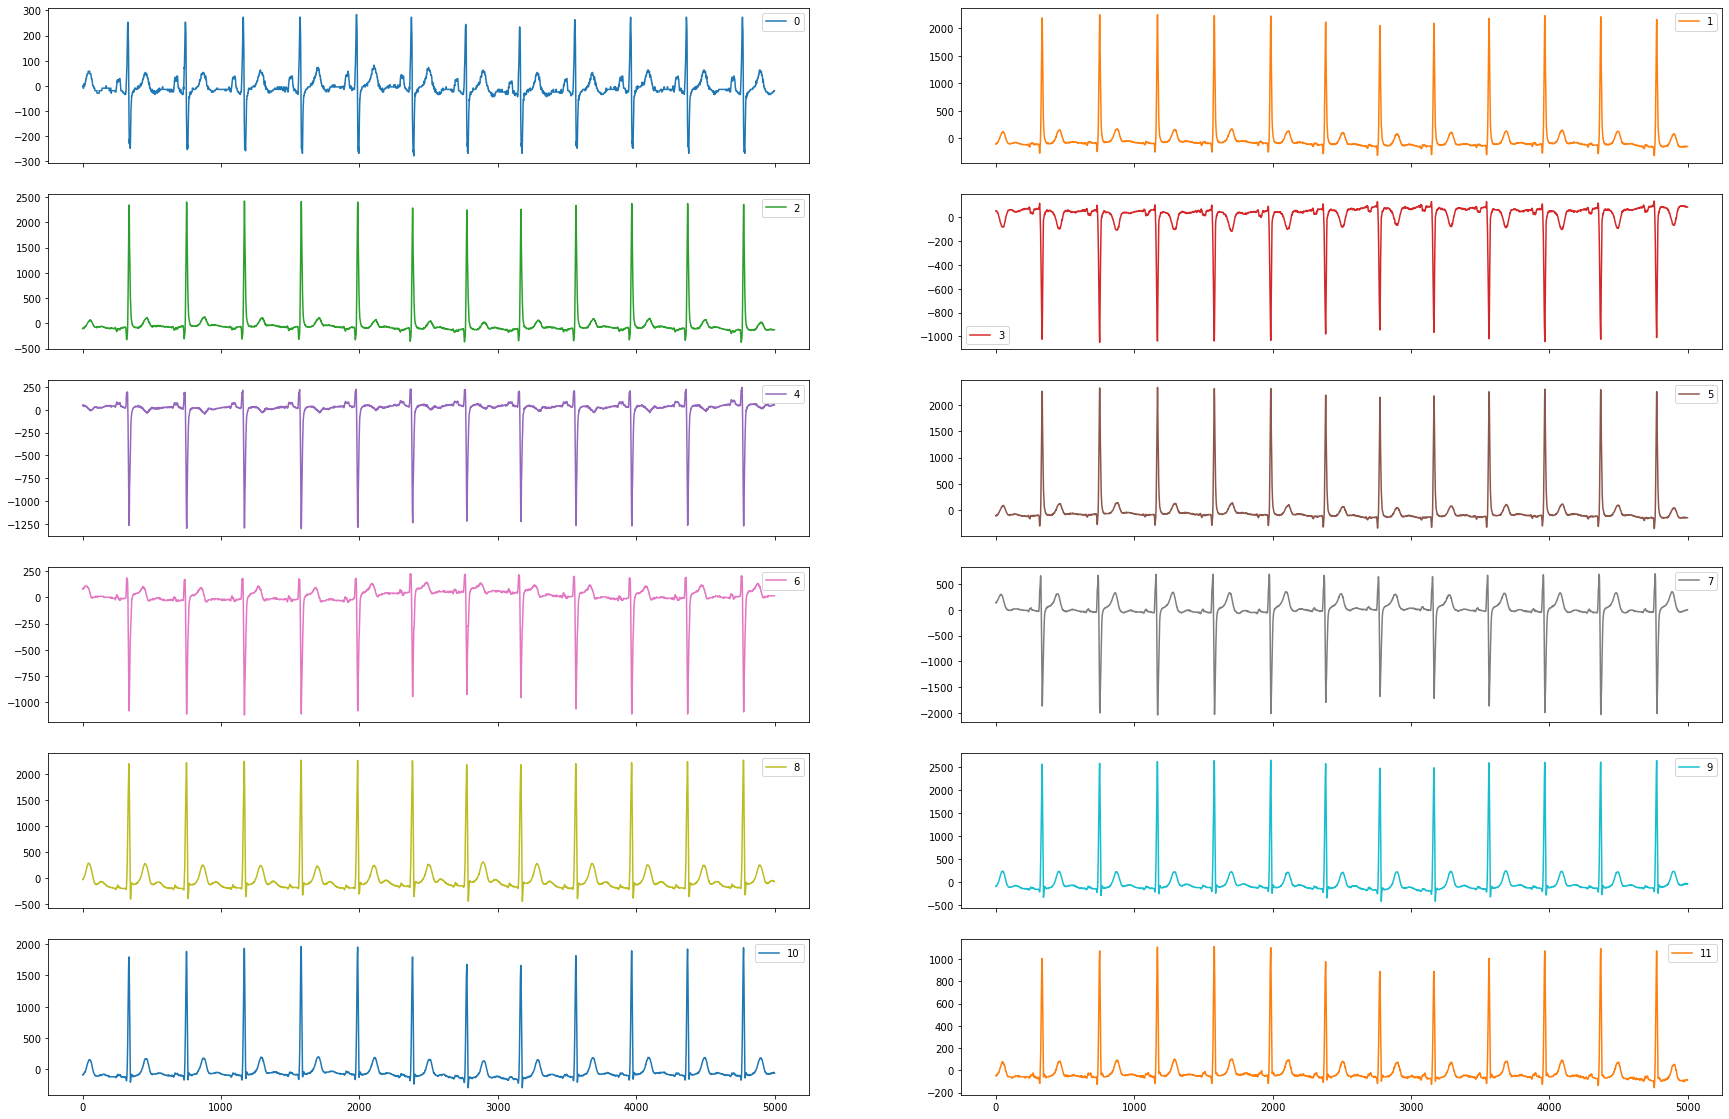

In [3]:
leads = load_recording(df["leads"][1000])
# print(leads.shape)
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

In [4]:
# ecg dataloder
class ECG_Dataset(Dataset):

    def __init__(self, df, length = 2500, transform=None):
        self.ecg_df = df
        self.transform = transform
        self.max_length = length
    def __len__(self):
        return len(self.ecg_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.ecg_df.iloc[idx]
        try: 
            enp = load_recording(row["leads"])[:,0:self.max_length]
        except Exception as e:
                print(e)
                enp = np.zeros([12,self.max_length])
                pass
        enp = np.nan_to_num(enp,0) # prevent nans from occuring

        sample = {
#                     "idx":idx_num,
                "leads":row["leads"],
                "headers":row["headers"],
                "labels": list(row.drop(labels=["leads","headers"]).keys()),
                "y": list(row.drop(labels=["leads","headers"]).to_numpy()),
                'leads': enp,
#                 "nsamples": row["nsamples"],
#                 "duration": row["duration"],
                }

        if self.transform:
            sample = self.transform(sample)

        return sample

train_val, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train_val, test_size=0.2)
train_loader = DataLoader(ECG_Dataset(train), batch_size=4,
                        shuffle=True, ) 
test_loader = DataLoader(ECG_Dataset(test), batch_size=32,
                        shuffle=True, ) 
# val_loader = DataLoader(ECG_Dataset(val), batch_size=32,
#                         shuffle=True, ) 


# Load memmap

In [ ]:
from helper_code import *
from team_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
directories = glob("dataset/*/", recursive = True)
d = directories[0]
dataset = d.split("/")[-2]
header_files, recording_files = find_challenge_files(d)
num_recordings = len(recording_files)

if not num_recordings:
    raise Exception('No data was provided.')

# Extract the classes from the dataset.

classes = set()
for header_file in header_files:
    header = load_header(header_file)
    classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
num_classes = len(classes)

# Extract the features and labels from the dataset.

print('Extracting features and labels for %s'%dataset)
print("\n")
data = np.zeros((num_recordings, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
labels = np.zeros((num_recordings, num_classes), dtype=np.bool_) # One-hot encoding of classes
label_names = []
for i in range(num_recordings):
    print('    {}/{}...'.format(i+1, num_recordings),end="\r")

    # Load header and recording.
    header = load_header(header_files[i])
    recording = load_recording(recording_files[i])

    # Get age, sex and root mean square of the leads.
    age, sex, rms = get_features(header, recording, twelve_leads)
    data[i, 0:12] = rms
    data[i, 12] = age
    data[i, 13] = sex

    current_labels = get_labels(header)
    label_names.append(current_labels[0])
    for label in current_labels:
        if label in classes:
            j = classes.index(label)
            labels[i, j] = 1


In [95]:
leads = [load_recording(r)[:,0:2500] for r in recording_files]
X =  np.array(leads)
y = np.array([l[0] for l in label_names])

# apply a model

In [86]:
from tsai.all import *
computer_setup()

os             : Linux-4.15.0-70-generic-x86_64-with-glibc2.10
python         : 3.8.5
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.8.1+cu101
n_cpus         : 96
device         : cuda (Tesla V100-SXM2-32GB)


In [96]:
# X, y, splits = get_classification_data('LSST', split_data=False)

batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)


RuntimeError: Can only calculate the mean of floating types. Got Short instead.

memmap(['g', 'c', 'f', ..., 'e', 'f', 'd'], dtype='<U1')